# Notebook For Figure 3 Method Paper

### Imports  
All functions are in behavior_analysis_functions.py

In [1]:
import os
import glob
from processing_TowerCoordinates import *
from processing_session_trajectory import *
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
import matplotlib.path as mpath
import matplotlib.cm as cm
import matplotlib.patches as patches
from matplotlib.gridspec import GridSpec
from matplotlib.colors import Normalize
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import numpy as np
import pickle
import scipy.ndimage as ndimage
from scipy.stats import wilcoxon
from processing_TowerCoordinates import *
from datetime import date
from scipy.ndimage import gaussian_filter as smooth
import matplotlib.colors as mcolors

import warnings 
from matplotlib.colors import LinearSegmentedColormap


plt.style.use('paper.mplstyle')

#from PlottingFunctions import *




# Getting mice data
Define the folder where your MOUXXX folder are, generate a list of MOUXXX folders and for each mice a list of sessions

In [2]:
# Finding and importing data

# indicate where the data are
# path_to_data_folder is the path of the folder where you store your different mice.

# Windows:
# path_to_data_folder='C:'+os.sep+'Users'+os.sep+'MORVAN'+os.sep+'Documents'+os.sep+'patchouris'+os.sep+'Sample_Data'+os.sep
# Linux:
# path_to_data_folder '/home/david/Documents/Code/ForagingProject/Patchouris/patchouris/Sample_Data/'
# MacOs
#path_to_data_folder = '/Users/davidrobbe/Documents/Science/Data/ForagingMice/'


#path_to_data_folder='/home/david/Documents/David/Data/'
#path_to_data_folder='/LocalData/ForagingMice/JAK2Data'
#path_to_data_folder='/LocalData/ForagingMice/MaudData'
#path_to_data_folder='/LocalData/ForagingMice/4TowerTaskMethodPaper/KenzaData'
#path_to_data_folder = '/Users/davidrobbe/Documents/Science/Data/ForagingMice/KenzaData'
path_to_data_folder='/LocalData/ForagingMice/4TowerTaskMethodPaper/MaudData'


pattern_of_MOU_Folders = os.path.join(path_to_data_folder, "MOU*")

# List all mice in the data folder (If you want to process all the mice in your data folder),
mice_list = [os.path.basename(path) for path in glob.glob(pattern_of_MOU_Folders)]
mice_list=sorted(mice_list)

# Print the number of mice, the list of mice, and add an empty line
print(f'Found {len(mice_list)} {"mice" if len(mice_list) > 1 else "mouse"} in the data folder: {", ".join(mice_list)}\n')


#If you want to process a subset of mice uncomment the line below and comment the 2 lines above

#mice_list: list[str] = ["MOU2334"]  # For processing  a single mice. Equivalent to mice_list = ["MOU2334"] but more correct as it forces to create a list of string
#mice_list=['MOU2329', 'MOU2330', 'MOU2331', 'MOU2332', 'MOU2333', 'MOU2334']
#print(f'Found {len(mice_list)} {"mice" if len(mice_list) > 1 else "mouse"} in the data folder:')

session_list = {}
for mouse in mice_list:
    mouse_folder = os.path.join(path_to_data_folder,mouse)
    session_list[mouse] = sorted([name for name in os.listdir(mouse_folder)
                           if os.path.isdir(os.path.join(mouse_folder, name))
                           and name.startswith('MOU')])
    nb_sessions = len(session_list[mouse])
    print(f'Hello, I\'m {mouse}! I have foraged for {nb_sessions} sessions:')
    print(session_list[mouse], '\n')


Found 30 mice in the data folder: MOU3974, MOU3975, MOU3987, MOU3988, MOU3991, MOU3992, MOU4122, MOU4123, MOU4124, MOU4172, MOU4175, MOU4183, MOU4185, MOU4186, MOU4192, MOU4551, MOU4552, MOU4560, MOU4561, MOU4562, MOU4563, MOU4623, MOU4624, MOU4692, MOU4694, MOU4695, MOU4696, MOU4698, MOU4703, MOU4704

Hello, I'm MOU3974! I have foraged for 46 sessions:
['MOU3974_20230304-1314', 'MOU3974_20230305-1535', 'MOU3974_20230306-1211', 'MOU3974_20230306-1752', 'MOU3974_20230307-1231', 'MOU3974_20230307-1742', 'MOU3974_20230308-1150', 'MOU3974_20230308-1714', 'MOU3974_20230309-1155', 'MOU3974_20230309-1705', 'MOU3974_20230310-1220', 'MOU3974_20230310-1702', 'MOU3974_20230311-1258', 'MOU3974_20230311-1801', 'MOU3974_20230312-1145', 'MOU3974_20230312-1648', 'MOU3974_20230313-1129', 'MOU3974_20230313-1725', 'MOU3974_20230314-1036', 'MOU3974_20230314-1620', 'MOU3974_20230315-1155', 'MOU3974_20230315-1722', 'MOU3974_20230316-1145', 'MOU3974_20230316-1653', 'MOU3974_20230317-1141', 'MOU3974_20230317-

# Definition of functions

In [3]:
# def cm2inch(value):

def cm2inch(value):
    return value/2.54

In [4]:
def compute_average_direction(points):
    diffs = np.diff(points, axis=0)
    avg_diff = np.mean(diffs, axis=0)
    angle = np.arctan2(avg_diff[1], avg_diff[0])
    return avg_diff, angle

In [5]:
def detect_run_epochs(speeds, time_video_frames):
    """
    
    Identifies continuous epochs during which the mouse is moving above a certain speed (cut_off_speed).
    A minimal duration of low speed is necessary to be considered as the end of a run.
    Similarly, a minimal duration of high speed is necessary to be considered as a run.
    """
    
    #for this we need some parameters to cut the trajectory into run based on speed, duration of runs and pauses
    pause_min_duration = 0.1 #if a stop is shorter than this, merges the two epochs bordering it
    run_min_duration = 0.3 #minimal duration of an epoch to be considerd
    cut_off_speed = 7 # this value is the speed in cm/s. It is used to detect when the animals stop running. 
    
    
    
    run_epochs = []
    is_in_epoch = False  # Flag to track if we are currently in a running epoch
    epoch_start_index = 0

    if len(speeds) != len(time_video_frames):
        raise ValueError("speeds and time_video_frames have different lengths")

    for i in range(len(speeds)):
        if speeds[i] >= cut_off_speed:  # Speed above cut-off value
            if not is_in_epoch: # if the previous trajectory speed was not part of running epoch then this will be a start of a new epoch
                epoch_start_index = i  # Mark the beginning of a new epoch
                is_in_epoch = True
        else: # the speed of the current data point is below the treshold
            if is_in_epoch: # if we were in a run epoch just before (1st point below the treshold)
                # Check first if the pause between this epoch's starting point (time_video_frames[epoch_start_index]) and  
                # the previous epoch' last point time_video_frames[run_epochs[-1][1]] is shorter than the minimal time for a pause
                # then the previous epoch  should be extended to the previous data point.  
                if run_epochs and (time_video_frames[epoch_start_index] - time_video_frames[run_epochs[-1][1]] < pause_min_duration):
                    run_epochs[-1][1] = i - 1  # Extend the previous epoch
                else: # the pause has been long enough then we terminate the run epoch  other previous 
                    run_epochs.append([epoch_start_index, i - 1])  # Add new epoch
                is_in_epoch = False

    # Final check for any epoch still in progress
    if is_in_epoch:
        if run_epochs and (time_video_frames[epoch_start_index] - time_video_frames[run_epochs[-1][1]] < pause_min_duration):
            run_epochs[-1][1] = len(speeds) - 1
        elif (time_video_frames[-1] - time_video_frames[epoch_start_index]) >= run_min_duration:
            run_epochs.append([epoch_start_index, len(speeds) - 1])

    # Remove epochs that are too short
    run_epochs = [epoch for epoch in run_epochs if (time_video_frames[epoch[1]] - time_video_frames[epoch[0]]) >= run_min_duration]
    
    # Adjust the start and end of each epoch based on acceleration. The idea is that with the threshold method we miss the beginning and enf of the run
    # for the starting point. We are going back and find the point at wich the animal acceleration is less than 40% 
    # than the acceleration at the moment at which he passed the treshold. 
    clean_run_epochs = [None] * len(run_epochs)
    for index,epoch in enumerate(run_epochs):
        clean_run_epochs[index] = epoch.copy()
        epoch_start, epoch_end = epoch[0], epoch[1]
        # Adjust the start of the epoch
        current_point = epoch_start
        acceleration_at_crossing=(speeds[current_point + 1] - speeds[current_point]) / (time_video_frames[current_point + 1] - time_video_frames[current_point])
        while current_point > 0:
            previous_acceleration = (speeds[current_point] - speeds[current_point - 1]) / (time_video_frames[current_point] - time_video_frames[current_point - 1])
            if previous_acceleration <= (0.1 * acceleration_at_crossing) or previous_acceleration <= 0:
                break
            current_point -= 1
            #print(f'it went backward on epoch {index}')
        clean_run_epochs[index][0] = current_point

    #Adjust the end of the epoch
    #We are going forward after the speed crossed downward the speed threshold and find the point at wich the animal acceleration is less than 40% 
    #than the acceleration at the moment at which it passed the treshold. 
        current_point = epoch_end
        acceleration_at_crossing=(speeds[current_point - 1] - speeds[current_point]) / (time_video_frames[current_point] - time_video_frames[current_point-1])
        while current_point < len(speeds) - 1:
            next_acceleration = (speeds[current_point] - speeds[current_point + 1]) / (time_video_frames[current_point+1] - time_video_frames[current_point])
            if next_acceleration <= (0.1 * acceleration_at_crossing) or next_acceleration <= 0:
                break
            current_point += 1
            #print(f'it went forward on epoch {index}')
        clean_run_epochs[index][1] = current_point

    
   
    return run_epochs, clean_run_epochs

In [6]:
def find_run_type(run_epoch, folder_path_mouse_to_analyse, session_to_analyse):

    # Define the pickle file path
    output_pickle_filename = f"{session_to_analyse}_basic_processing_output.pickle"
    output_pickle_filepath = os.path.join(folder_path_mouse_to_analyse, session_to_analyse, output_pickle_filename)
    
    # Load the pickle file
    with open(output_pickle_filepath, 'rb') as file:
        session_data = pickle.load(file)

    
    run_around_tower_ids = np.array([item[0] for item in session_data['all_epochs']['run_around_tower']])
    run_between_towers_ids = np.array([item[0] for item in session_data['all_epochs']['run_between_towers']])
    exploratory_run_ids = np.array([item[0] for item in session_data['all_epochs']['exploratory_run']])
    run_toward_tower_ids = np.array([item[0] for item in session_data['all_epochs']['run_toward_tower']])
    #print(immobility_ids)
    immobility_ids = np.array([[item[0],item[1]] for item in session_data['all_epochs']['immobility']])
    
    # condition_1 = np.logical_and(run_around_tower_ids[0][:]<=run_epoch[0],run_around_tower_ids[1][:]>run_epoch[1])
    # condition_2 = np.logical_and(run_between_towers_ids[0][:]<=run_epoch[0],run_between_towers_ids[1][:]>run_epoch[1])
    # condition_3 = np.logical_and(run_toward_tower_ids[0][:]<=run_epoch[0],run_toward_tower_ids[1][:]>run_epoch[1])
    # condition_4 = np.logical_and(exploratory_run_ids[0][:]<=run_epoch[0],exploratory_run_ids[1][:]>run_epoch[1])
    # condition_5 = np.logical_and(immobility_ids[0][:]<=run_epoch[0],immobility_ids[1][:]>run_epoch[1])
    
    condition_1 = run_epoch in run_around_tower_ids
    condition_2 = run_epoch in run_between_towers_ids
    condition_3 = run_epoch in run_toward_tower_ids
    condition_4 = run_epoch in exploratory_run_ids
    condition_5 = run_epoch in immobility_ids
    

    if np.any(condition_1):
    
        epoch_type = "run_around_tower"
        
    elif np.any(condition_2):
    
        epoch_type = "run_between_towers"

    elif np.any(condition_3):
    
        epoch_type = "run_toward_tower"    

    elif np.any(condition_4):
    
        epoch_type = "exploratory_run"

    elif np.any(condition_5):
    
        epoch_type = "immobility"    

    else:
        
        print("WARNING: unclassified epoch")
        epoch_type = "unclassified"

    print(f"Epoch type found for epoch: {run_epoch}")


    return epoch_type


In [7]:
def finding_mouse_rewarded_direction(folder_path_mouse_to_analyse):
# Looking for the rewarded direction FOR ALL THE SESSIONS

    sessions_to_analyse = sorted([name for name in os.listdir(folder_path_mouse_to_analyse)
                                  if os.path.isdir(os.path.join(folder_path_mouse_to_analyse, name))
                                  and name.startswith('MOU')])

    #with open(output_pickle_filepath, 'rb') as file:
    #        session_data = pickle.load(file)

    session_traj_df, session_turns_df, session_param_df=load_data(folder_path_mouse_to_analyse,sessions_to_analyse[-1])

    rewarded_direction_degrees = session_param_df["potentialRewardedDirections"][0]

    if rewarded_direction_degrees == '[270]':

        rewarded_direction = 'CW'

    elif rewarded_direction_degrees == '[90]':
        
        rewarded_direction = 'CCW'
        
    else:

        print('ERROR')

        return 

    return rewarded_direction
    
    #

In [8]:
def plot_runs_between_speed_profiles(folder_path_mouse_to_analyse, session_to_analyse, ax, time_start=None, time_end=None, xlim=None, ylim=None, show_xlabel=True, show_ylabel=True, show_color_bar=True):

    output_pickle_filename = f"{session_to_analyse}_basic_processing_output.pickle"        
    output_pickle_filepath = os.path.join(folder_path_mouse_to_analyse, session_to_analyse, output_pickle_filename)

    with open(output_pickle_filepath, 'rb') as file:
        session_data = pickle.load(file)

    #traj_df, turns_df, param_df=load_data(folder_path_mouse_to_analyse,session_to_analyse)

    traject_time = session_data['timeofframes']

    if time_start is None:
        time_start = traject_time[0]
    if time_end is None:
        time_end = traject_time[-1]

    # distances = session_data['distances']
    # speeds = session_data['speeds']
    # angular_speeds = session_data['angular_speeds']


    smoothed_positions = session_data['positions']
    smoothed_Xpositions = smoothed_positions[0]
    smoothed_Ypositions = smoothed_positions[1]
    speeds = session_data['speeds']

    runs_between_towers = copy.deepcopy(session_data['all_epochs']['run_between_towers'])


    n_total = 0

    for run_between_towers in runs_between_towers:

        start_index, end_index = run_between_towers[0][0], run_between_towers[0][1]
        
        if traject_time[start_index]<time_start or traject_time[end_index]>time_end:
        
            continue

        n_total += 1

    timeANDmedian_speed_of_runs = []
    cmap = plt.cm.viridis
    norm = Normalize(vmin=0, vmax=n_total)

    local_index = 0

    for run_between_towers in runs_between_towers:

        start_index, end_index = run_between_towers[0][0], run_between_towers[0][1]

        if traject_time[start_index]<time_start or traject_time[end_index]>time_end:
        
            continue

        runtype_epoch_Xpositions = smoothed_Xpositions[start_index:end_index + 1]
        runtype_epoch_Ypositions = smoothed_Ypositions[start_index:end_index + 1]

        if len(runtype_epoch_Xpositions) != len(runtype_epoch_Ypositions):
            raise ValueError("The lengths of X and Y positions lists must be the same.")

        adjusted_time = [t - traject_time[start_index] for t in traject_time[start_index:end_index + 1]]
        ax.plot(adjusted_time, speeds[start_index:end_index + 1], color=cmap(norm(local_index)))
        timeANDmedian_speed_of_runs.append([traject_time[start_index], np.median(speeds[start_index:end_index + 1]),np.max(speeds[start_index:end_index + 1])])

        local_index += 1 
    
    if show_xlabel:

        ax.set_xlabel('Time (s)', fontsize=5)
    
    if show_ylabel:
    
        ax.set_ylabel('Speed (cm/s)', fontsize=5)

    ax.set_xlim(xlim)
    ax.set_ylim(ylim)

    # Create an additional axes for the colorbar
    if show_color_bar:
        cbax = ax.inset_axes([0.25, 0.8, 0.5, 0.07]) 
        cbar = fig.colorbar(plt.cm.ScalarMappable(cmap=cmap, norm=norm), cax=cbax, orientation='horizontal')
        cbar.set_label('Index of Run', fontsize=5)
        cbar.set_ticks([0, n_total])
        cbar.set_ticklabels(['First', 'Last'], fontsize=5)

In [9]:
def plot_runs_between_towers_origin(folder_path_mouse_to_analyse, session_to_analyse, ax, q=4, time_start=None, time_end=None, show_legend=True, xlim=None, ylim=None, show_xlabel=True, show_ylabel=True):
    
    output_pickle_filename = f"{session_to_analyse}_basic_processing_output.pickle"        
    output_pickle_filepath = os.path.join(folder_path_mouse_to_analyse, session_to_analyse, output_pickle_filename)

    with open(output_pickle_filepath, 'rb') as file:
        session_data = pickle.load(file)

    #traj_df, turns_df, param_df=load_data(folder_path_mouse_to_process,session_to_process)

    traject_time = session_data['timeofframes']

    if time_start is None:
        time_start = traject_time[0]
    if time_end is None:
        time_end = traject_time[-1]

    # distances = session_data['distances']
    # speeds = session_data['speeds']
    # angular_speeds = session_data['angular_speeds']


    smoothed_positions = session_data['positions']
    smoothed_Xpositions = smoothed_positions[0]
    smoothed_Ypositions = smoothed_positions[1]

    runs_around_tower = copy.deepcopy(session_data['all_epochs']['run_between_towers'])

    
    fixed_origin = (0, 0)  # Define a fixed origin point
    #cmap = plt.cm.viridis
    #norm = Normalize(vmin=0, vmax=len(runs_around_tower))
    labels_displayed = set()
    
    for run_around_tower in runs_around_tower:
        
        # if run_around_tower[3]['num_trapezeswitch'] > 1:
        #     continue

        start_index, end_index = run_around_tower[0][0], run_around_tower[0][1]

        if traject_time[start_index]<time_start or traject_time[end_index]>time_end:
        
            continue

        runtype_epoch_Xpositions = smoothed_Xpositions[start_index:end_index + 1]
        runtype_epoch_Ypositions = smoothed_Ypositions[start_index:end_index + 1]
        numberofpositions = len(runtype_epoch_Xpositions)
        
        colors = [(0, 1, 0), (1, 0.5, 0), (1, 0, 0)] # Green to orange to red
        cmap = LinearSegmentedColormap.from_list('custom_cmap', colors)
    #    cmap = plt.get_cmap('plasma')
        #colorgradientforthisrun = cmap(np.linspace(0, 1, numberofpositions)) 
        #custom_cmap(numberofpositions)  # Generate color gradient for this run

        start_x, start_y = runtype_epoch_Xpositions[0], runtype_epoch_Ypositions[0]
        translated_Xpositions = [x - start_x + fixed_origin[0] for x in runtype_epoch_Xpositions]
        translated_Ypositions = [y - start_y + fixed_origin[1] for y in runtype_epoch_Ypositions]

        #rewarded_direction = finding_mouse_rewarded_direction(folder_path_mouse_to_process)

        color = '#7CBD7C'

        for i in range(numberofpositions - 1):


            if i==0:

                line_label = 'Good turns'
                labels_displayed.add('violet')
                
            else:

                line_label = ''
            
            ax.plot(translated_Xpositions[i:i+2], translated_Ypositions[i:i+2], color=color, linewidth=0.5, label=line_label)

        ax.plot(translated_Xpositions[0], translated_Ypositions[0], marker='o', color='black', linewidth=0.5, markersize=1)                                                                                                                             

        if len(translated_Xpositions) >= q:
            dx = translated_Xpositions[-1] - translated_Xpositions[-q]
            dy = translated_Ypositions[-1] - translated_Ypositions[-q]
            norm_speed = np.hypot(dx, dy)
            if norm_speed != 0:
                dx /= norm_speed
                dy /= norm_speed
            ax.arrow(translated_Xpositions[-1], translated_Ypositions[-1], dx, dy,
                                       head_width=1, head_length=1, fc='red', ec='red')

    if show_xlabel:
        
        ax.set_xlabel('X Position (cm)')
    
    if show_ylabel:
        
        ax.set_ylabel('Y Position (cm)')

    ax.set_xlim(xlim)
    ax.set_ylim(ylim)

    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)

    if show_legend:
        ax.legend(loc=[0.4,1.2],frameon=False, fontsize=4)

    # if show_color_bar:
    #     cbax = ax.inset_axes([0.25, 1.2, 0.5, 0.05])         
    #     cbar = fig.colorbar(plt.cm.ScalarMappable(cmap=cmap, norm=norm), cax=cbax, orientation='horizontal')
    #     cbar.set_label('Timeline of run', fontsize=5)
    #     cbar.set_ticks([0, len(runs_around_tower)])
    #     cbar.set_ticklabels(['Start', 'End'], fontsize=5)


In [10]:
def towers_coordinates_as_dictionnary(towers_coordinates_cm):

    # Define new dictionary with explicit corner names
    towers_coordinates_as_dict = {}

    # Corner names in order
    corner_names = ['NW', 'NE', 'SE', 'SW']

    # Map tower coordinates to corner names
    for tower, coordinates in towers_coordinates_cm.items():
        towers_coordinates_as_dict[tower] = {corner_names[i]: coord for i, coord in enumerate(coordinates)}

    return towers_coordinates_as_dict


In [11]:
def get_tower_and_corner(run_around_tower):
    # Get the label of the tower and corner  around wich a run around tower is happening based on the  second and third elements saved in run_epochs['run_around_tower']
    tower_name = run_around_tower[1][0]  # First element, 'NE', gives the tower
    start_face = run_around_tower[1][1]  # 'W' for west, gives the starting face
    end_face = run_around_tower[2][1]    # 'S' for south, gives the ending face
    
    # Determine the corner based on the start and end faces
    if start_face == 'W' and end_face == 'S':
        corner = 'SW'
    elif start_face == 'S' and end_face == 'E':
        corner = 'SE'
    elif start_face == 'E' and end_face == 'N':
        corner = 'NE'
    elif start_face == 'N' and end_face == 'W':
        corner = 'NW'
    elif start_face == 'W' and end_face == 'N':
        corner = 'NW'
    elif start_face == 'N' and end_face == 'E':
        corner = 'NE'
    elif start_face == 'E' and end_face == 'S':
        corner = 'SE'
    elif start_face == 'S' and end_face == 'W':
        corner = 'SW'
    else:
        corner = None  # Handle unexpected cases
    
    return tower_name, corner

In [12]:
def plot_trajectories(trajectories,marker='o'):
    """
    Plot all trajectories on the same plot.
    
    Parameters:
        trajectories (list): A list of 2D numpy arrays of shape (2, X) representing the trajectories.
    """
    plt.figure(figsize=(8, 6))
    
    # Plot each trajectory
    for trajectory in trajectories:
        plt.plot(trajectory[0, :], trajectory[1, :], marker=marker, linestyle='-', label='Trajectory')
        plt.scatter(trajectory[0, 0], trajectory[1, 0], color='green', marker='o', edgecolor='green', label='Start Point',s=40)
        plt.scatter(trajectory[0, -1], trajectory[1, -1], color='red', marker='o', edgecolor='red', label='End Point',s=40) 
    
    # Add labels and title
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.title('All Trajectories')
    plt.grid(True)
    
    # Show the plot
    plt.show()

In [13]:
def rotate_SWtrajectory_90_ccw(trajectory):
    rotation_matrix = np.array([[0, -1], [1, 0]])
    return rotation_matrix @ trajectory


In [14]:
def rotate_NWtrajectory_180_ccw(trajectory):
    return -trajectory


In [15]:
def rotate_NEtrajectory_270_ccw(trajectory):
    rotation_matrix = np.array([[0, 1], [-1, 0]])
    return rotation_matrix @ trajectory


In [16]:
def resample_trajectory(trajectory, target_size):
    """
    Resample a single trajectory to have the target number of points.
    
    Parameters:
        trajectory (np.ndarray): A 2D numpy array of shape (2, X).
        target_size (int): The target number of points (X).
        
    Returns:
        np.ndarray: A 2D numpy array of shape (2, target_size).
    """
    # Get current number of points
    current_size = trajectory.shape[1]
    
    # Create an array of indices for the original points and the target points
    original_indices = np.linspace(0, current_size - 1, num=current_size)
    target_indices = np.linspace(0, current_size - 1, num=target_size)
    
    # Resample by interpolating the trajectory for each row (x and y coordinates)
    resampled_trajectory = np.array([np.interp(target_indices, original_indices, trajectory[i, :])
                                     for i in range(2)])
    
    return resampled_trajectory



In [17]:
def resample_all_trajectories(all_trajectories, target_size):
    """
    Resample all trajectories to have the same target number of points.
    
    Parameters:
        all_trajectories (list): A list of 2D numpy arrays of shape (2, X).
        target_size (int): The target number of points for each trajectory.
        
    Returns:
        list: A list of resampled 2D numpy arrays of shape (2, target_size).
    """
    resampled_trajectories = [resample_trajectory(trajectory, target_size) for trajectory in all_trajectories]
    return resampled_trajectories


In [18]:
def compute_pairwise_correlations(trajectories):
    """Compute pairwise correlations between trajectories."""
    num_trajectories = len(trajectories)
    print(f"Number of trajectories: {num_trajectories}")
    correlations = []
    
    for i in range(num_trajectories):
        for j in range(i + 1, num_trajectories):
            traj1 = trajectories[i]
            #print(len(traj1))
            traj2 = trajectories[j]
            #print(len(traj2))
            
            # Flatten trajectories for correlation computation
            traj1_flat = traj1.flatten()
            #print(len(traj1_flat))
            traj2_flat = traj2.flatten()
            #print(len(traj2_flat))
            
            # Compute correlation coefficient
            corr = np.corrcoef(traj1_flat, traj2_flat)[0, 1]
            correlations.append(corr)
    
    return correlations

In [19]:
def accumulation_threshold(cummulated_events_time, threshold=0.8):

    i = 0

    fraction_of_events = (i+1)/len(cummulated_events_time)

    while fraction_of_events<threshold:

        i = i + 1
        fraction_of_events = (i+1)/len(cummulated_events_time)

    return cummulated_events_time[i]

In [20]:
"""def cumulated_runs_time_profile(folder_path_mouse_to_analyse, session_to_analyse, time_start=None, time_end=None):

    output_pickle_filename = f"{session_to_analyse}_basic_processing_output.pickle"        
    output_pickle_filepath = os.path.join(folder_path_mouse_to_analyse, session_to_analyse, output_pickle_filename)

    with open(output_pickle_filepath, 'rb') as file:
        session_data = pickle.load(file)

    traject_time = session_data['timeofframes']

    if time_start is None:
        time_start = traject_time[0]
    if time_end is None:
        time_end = traject_time[-1]
  
    runs_between_towers = copy.deepcopy(session_data['all_epochs']['run_between_towers'])

    runs_between_towers_to_keep = []

    time_of_runsbetweentowers = []

    for run_between_towers in runs_between_towers:
        
        # if run_around_tower[3]['num_trapezeswitch'] > 1:
        #     continue

        start_index, end_index = run_between_towers[0][0], run_between_towers[0][1]

        if traject_time[start_index]<time_start or traject_time[end_index]>time_end:
        
            continue
        
        time_of_runsbetweentowers.append(run_between_towers[3]['time'])

        runs_between_towers_to_keep.append(run_between_towers)

    runs_times_sorted = np.sort(time_of_runsbetweentowers)
    
    runs_cumulative = np.arange(1, len(runs_times_sorted) + 1)
    
    return runs_times_sorted, runs_cumulative
    """

'def cumulated_runs_time_profile(folder_path_mouse_to_analyse, session_to_analyse, time_start=None, time_end=None):\n\n    output_pickle_filename = f"{session_to_analyse}_basic_processing_output.pickle"        \n    output_pickle_filepath = os.path.join(folder_path_mouse_to_analyse, session_to_analyse, output_pickle_filename)\n\n    with open(output_pickle_filepath, \'rb\') as file:\n        session_data = pickle.load(file)\n\n    traject_time = session_data[\'timeofframes\']\n\n    if time_start is None:\n        time_start = traject_time[0]\n    if time_end is None:\n        time_end = traject_time[-1]\n  \n    runs_between_towers = copy.deepcopy(session_data[\'all_epochs\'][\'run_between_towers\'])\n\n    runs_between_towers_to_keep = []\n\n    time_of_runsbetweentowers = []\n\n    for run_between_towers in runs_between_towers:\n        \n        # if run_around_tower[3][\'num_trapezeswitch\'] > 1:\n        #     continue\n\n        start_index, end_index = run_between_towers[0][0],

In [21]:
def plot_cumulated_runs_time_profile(folder_path_mouse_to_analyse, session_to_analyse, ax, time_start=None, time_end=None, xlim=None, ylim=None, show_xlabel=True, show_ylabel=True, show_legend=True):

    output_pickle_filename = f"{session_to_analyse}_basic_processing_output.pickle"        
    output_pickle_filepath = os.path.join(folder_path_mouse_to_analyse, session_to_analyse, output_pickle_filename)

    with open(output_pickle_filepath, 'rb') as file:
        session_data = pickle.load(file)

    traject_time = session_data['timeofframes']

    if time_start is None:
        time_start = traject_time[0]
    if time_end is None:
        time_end = traject_time[-1]
  
    runs_between_towers = copy.deepcopy(session_data['all_epochs']['run_between_towers'])

    runs_between_towers_to_keep = []

    time_of_runsbetweentowers = []

    for run_between_towers in runs_between_towers:
        
        # if run_around_tower[3]['num_trapezeswitch'] > 1:
        #     continue

        start_index, end_index = run_between_towers[0][0], run_between_towers[0][1]

        if traject_time[start_index]<time_start or traject_time[end_index]>time_end:
        
            continue
        
        time_of_runsbetweentowers.append(run_between_towers[3]['time'])

        runs_between_towers_to_keep.append(run_between_towers)

    runs_times_sorted = np.sort(time_of_runsbetweentowers)
    
    runs_cumulative = np.arange(1, len(runs_times_sorted) + 1)
    
    ax.step(runs_times_sorted, runs_cumulative, where='post', label='Rewarded direction', color='#7CBD7C')
    #ax.step(runs_times_sorted, runs_cumulative, where='post', label='Unrewarded direction', color='indigo')
    
    if show_xlabel:
        ax.set_xlabel('Time of turn (s)', fontsize=5)
    if show_ylabel:
        ax.set_ylabel('Cumulative number of runs', fontsize=5)

    ax.set_xlim(xlim)
    ax.set_ylim(ylim)
    
    #ax.set_title('Cumulative Dynamics of CW vs. CCW Runs')
    
    if show_legend:
        ax.legend(frameon=False, fontsize=4)
    
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    

In [22]:
def count_transition_number(runs_between_towers, towers):

    nb_of_runs = 0

    for idx, run_between_towers in enumerate(runs_between_towers):

        transition = [run_between_towers[1][0],run_between_towers[2][0]]

        if transition == towers:

            nb_of_runs = nb_of_runs + 1

    return nb_of_runs

In [23]:
def transition_map(folder_path_mouse_to_analyse, session_to_analyse):

    output_pickle_filename = f"{session_to_analyse}_basic_processing_output.pickle"        
    output_pickle_filepath = os.path.join(folder_path_mouse_to_analyse, session_to_analyse, output_pickle_filename)

    transitions = []

    with open(output_pickle_filepath, 'rb') as file:
        session_data = pickle.load(file)

    runs_between_towers = copy.deepcopy(session_data['all_epochs']['run_between_towers'])

    transitions = ['SW','SE','NE','NW']

    trans_map = np.zeros((4,4))

    for indexes, trans in np.ndenumerate(trans_map):

        trans_map[indexes] = count_transition_number(runs_between_towers, [transitions[indexes[0]],transitions[indexes[1]]])

        #print([transitions[indexes[0]],transitions[indexes[1]]])

    trans_map = trans_map/np.sum(trans_map)

    return trans_map

    #np.max(trans_map)

    #ax.set_xlim(xlim)
    #ax.set_ylim(ylim)



In [24]:
def is_injection(folder_path_mouse_to_analyse, session_to_analyse):

    session_traj_df, session_turns_df, session_param_df=load_data(folder_path_mouse_to_analyse,session_to_analyse)

    if 'injectionCNO' in session_param_df.keys():

        bool_injection = not(session_param_df["injectionCNO"][0] == 'none')

    else :

        bool_injection = "missing label"

    return bool_injection
    

In [25]:
def accumulation_threshold(cummulated_events_time, threshold=0.8):

    i = 0

    fraction_of_events = (i+1)/len(cummulated_events_time)

    while fraction_of_events<threshold:

        i = i + 1
        fraction_of_events = (i+1)/len(cummulated_events_time)

    return cummulated_events_time[i]

In [26]:
def find_rewarding_range(folder_path_mouse_to_analyse,session_to_analyse):

    session_traj_df, session_turns_df, session_param_df=load_data(folder_path_mouse_to_analyse,session_to_analyse)

    session_type = eval(list(session_param_df['range_maxConsecRewards'])[0])

    return session_type

In [27]:
def finding_session_rewarded_direction(folder_path_mouse_to_analyse, session_to_analyse):
# Looking for the rewarded direction FOR ALL THE SESSIONS

    # sessions_to_analyse = sorted([name for name in os.listdir(folder_path_mouse_to_analyse)
    #                               if os.path.isdir(os.path.join(folder_path_mouse_to_analyse, name))
    #                               and name.startswith('MOU')])

    #output_pickle_filename = f"{sessions_to_analyse[-1]}_basic_analysing_output.pickle"
    #output_pickle_filepath = os.path.join(folder_path_mouse_to_analyse, sessions_to_analyse[-1], output_pickle_filename)

    #with open(output_pickle_filepath, 'rb') as file:
    #        session_data = pickle.load(file)

    # session_traj_df, session_turns_df, session_param_df=load_data(folder_path_mouse_to_analyse,sessions_to_analyse[-1])

    session_traj_df, session_turns_df, session_param_df=load_data(folder_path_mouse_to_analyse,session_to_analyse)


    rewarded_direction_degrees = session_param_df["potentialRewardedDirections"][0]

    if rewarded_direction_degrees == '[270]':

        rewarded_direction = 'CW'

    elif rewarded_direction_degrees == '[90]':
        
        rewarded_direction = 'CCW'
        
    elif rewarded_direction_degrees == '[90, 270]':
    
        rewarded_direction = 'both'

    else:

        print(f'ERROR:{session_to_analyse}')

        return 

    return rewarded_direction
    
    #

In [28]:
def check_alternation(folder_path_mouse_to_analyse, session_limit):

    sessions_to_analyse = sorted([name for name in os.listdir(folder_path_mouse_to_analyse)
                                    if os.path.isdir(os.path.join(folder_path_mouse_to_analyse, name))
                                    and name.startswith('MOU')])

    sessions_to_analyse = sessions_to_analyse[:session_limit]

    rewarded_direction_per_session = []

    for session in sessions_to_analyse:

        rewarded_direction_per_session.append(finding_session_rewarded_direction(folder_path_mouse_to_analyse, session))

    for i in range(2,len(rewarded_direction_per_session)):

        if rewarded_direction_per_session[i] == rewarded_direction_per_session[i-2]:

            print(f"ERROR: The rewarded direction is not alternating every day for mouse {folder_path_mouse_to_analyse[-7:]} in session {i+1} or {i-1}")
            print(rewarded_direction_per_session)

            return False
        
    return True

In [29]:
def when_injection(folder_path_mouse_to_analyse):

    sessions_to_analyse = sorted([name for name in os.listdir(folder_path_mouse_to_analyse)
                                    if os.path.isdir(os.path.join(folder_path_mouse_to_analyse, name))
                                    and name.startswith('MOU')])
    
    injection_session_idx = []

    for idx, session in enumerate(sessions_to_analyse):

        is_inj = is_injection(folder_path_mouse_to_analyse, session)

        if is_inj=="missing label":
    
            print(f"injection label missing mouse {folder_path_mouse_to_analyse[-7:]} in session number ", idx+1)
    
        if is_inj:

            injection_session_idx.append(idx)

            if idx != 0:

                return injection_session_idx

    return injection_session_idx


In [30]:
def separate_directions(path_to_data_folder, mice, session_limit=None):

    CW_mice = []
    CCW_mice = []

    for mouse in mice:

        folder_path_mouse_to_analyse = os.path.join(path_to_data_folder, mouse)
        
        if not(check_alternation(folder_path_mouse_to_analyse, session_limit)):

            print(f"Excluding {mouse}")

            continue

        # Get the list of sessions
        sessions_to_analyse = sorted([name for name in os.listdir(folder_path_mouse_to_analyse)
                                    if os.path.isdir(os.path.join(folder_path_mouse_to_analyse, name))
                                    and name.startswith('MOU')])

        sessions_to_analyse = sessions_to_analyse[:session_limit]

        first_rewarded_direction = finding_session_rewarded_direction(folder_path_mouse_to_analyse, sessions_to_analyse[4])

        if first_rewarded_direction == 'CW':

            CW_mice.append(mouse)

        elif first_rewarded_direction == 'CCW':

            CCW_mice.append(mouse)

        else:
            
            print('No unique rewarded direction')
            return

        when_injection(folder_path_mouse_to_analyse)

    return CW_mice, CCW_mice



In [31]:
def is_rewarding_allowed(folder_path_mouse_to_analyse, session_to_analyse):

    session_traj_df, session_turns_df, session_param_df=load_data(folder_path_mouse_to_analyse,session_to_analyse)

    rewarding_session = session_param_df["allowRewardDelivery"][0]

    return rewarding_session
    

In [32]:
def plot_run_type(folder_path_mouse_to_process, session_to_process, ax, runtype='', q=4, time_start=None, time_end=None):
    
    output_pickle_filename = f"{session_to_process}_basic_processing_output.pickle"        
    output_pickle_filepath = os.path.join(folder_path_mouse_to_process, session_to_process, output_pickle_filename)

    with open(output_pickle_filepath, 'rb') as file:
        session_data = pickle.load(file)

    traject_time = session_data['timeofframes']

    if time_start is None:
        time_start = traject_time[0]
    if time_end is None:
        time_end = traject_time[-1]

    smoothed_positions = session_data['positions']
    smoothed_Xpositions = smoothed_positions[0]
    smoothed_Ypositions = smoothed_positions[1]

    all_epochs = session_data['all_epochs']

    all_trapezes_coordinates_cm = session_data['all_trapezes_coordinates_cm']


    if not runtype:
        warnings.warn("The 'runtype' parameter is required and was not provided.")
        return
    
    runtype_epochs = all_epochs.get(runtype)
    
    if runtype_epochs is None:
        warnings.warn(f"The 'runtype' '{runtype}' is not found in 'all_epochs'.")
        return
    
    #totaltime = 0
    #totaldistance = 0
    #meanspeed = []
    #maxspeed = []
    
    #distances, speeds = compute_distance_speed_angular_speed([smoothed_Xpositions, smoothed_Ypositions], traject_time)[0:2]
    
    # Plot each square and trapeze with the same color for each tower
    fill_colors = ['lightblue'] * 4
    
    for i, (tower, trapezes) in enumerate(all_trapezes_coordinates_cm.items()):
        for j, (trapeze, coordinates) in enumerate(trapezes.items()):
            # Close the polygon by appending the first vertex
            coordinates_copy = coordinates + [coordinates[0]]
            x_coords, y_coords = zip(*coordinates_copy)
            
            # Fill the trapezes if requested
            ax.fill(x_coords, y_coords, color=fill_colors[j % len(fill_colors)], alpha=0.5)
            
            # Plot trapeze borders if requested
            #ax.plot(x_coords, y_coords, color=border_colors[j % len(border_colors)], linestyle='--')
    
    # for tower, trapezes in all_trapezes_coordinates_cm.items():
        
    #     for trapeze, coordinates in trapezes.items():
    #         # Make a copy of the coordinates and close the polygon by appending the first vertex
    #         coordinates_copy = coordinates + [coordinates[0]]
    #         # Extract x and y coordinates for plotting
    #         x_coords, y_coords = zip(*coordinates_copy)
    #         ax.plot(x_coords, y_coords, label=f'{tower}_{trapeze}', color='gray',linestyle='--')

    for runtype_epoch in runtype_epochs:
        
        # if runtype=='run_around_tower':

        #     if runtype_epoch[3]['num_trapezeswitch'] > 1:
                
        #         continue
        
        start_index, end_index = runtype_epoch[0][0], runtype_epoch[0][1]

        if traject_time[start_index]<time_start or traject_time[end_index]>time_end:
        
            continue
        
        # Check if the indexes are within the bounds of the arrays
        if start_index < 0 or end_index >= len(traject_time):
            print(f"Indexes out of bounds for runtype_epoch: {runtype_epoch}")
            continue

        # Extract the run epoch, compute duration, distance and speed
        runtype_epoch_Xpositions = smoothed_Xpositions[start_index:end_index + 1]
        runtype_epoch_Ypositions = smoothed_Ypositions[start_index:end_index + 1]
        #epochduration = traject_time[end_index] - traject_time[start_index]
        #totaltime += epochduration
        #distanceran = np.sum(distances[start_index:end_index])
        #totaldistance += distanceran
        #meanspeed.append(distanceran / epochduration)
        #maxspeed.append(np.max(speeds[start_index:end_index]))

        numberofpositions=len(runtype_epoch_Xpositions)
    #     colors = [(0, 1, 0), (1, 0.5, 0), (1, 0, 0)] # Green to orange to red
    #     cmap = LinearSegmentedColormap.from_list('custom_cmap', colors)
    # #    cmap = plt.get_cmap('plasma')
    #     colorgradientforthisrun = cmap(np.linspace(0, 1, numberofpositions)) 

        # Ensure both lists have the same length
        if len(runtype_epoch_Xpositions) != len(runtype_epoch_Ypositions):
            raise ValueError("The lengths of X and Y positions lists must be the same.")

        #rewarded_direction = finding_session_rewarded_direction(folder_path_mouse_to_process,session_to_process)

        # Loop through the lists and obtain each pair of values with indices
        for index  in range(numberofpositions-2):

            if runtype=='run_around_tower':
                color = 'blue' if runtype_epoch[3]['direction'] == 'CW' else 'red'
            else:
                color = '#7CBD7C'
            #ax.plot(runtype_epoch_Xpositions[index:index+2],runtype_epoch_Ypositions[index:index+2],color=colorgradientforthisrun[index], linewidth=0.5)
            ax.plot(runtype_epoch_Xpositions[index:index+2],runtype_epoch_Ypositions[index:index+2],color=color, linewidth=0.5)
        
        # Plot the trajectory
        #ax1.plot(runtype_epoch_Xpositions, runtype_epoch_Ypositions, linestyle='-', label=f"Traj {start_index}-{end_index}")
        
        # Plot the start and end points
        ax.plot(runtype_epoch_Xpositions[0], runtype_epoch_Ypositions[0], color='black', marker='o', markersize=1)  # Start point

        # Compute the direction of the arrow using the last q points
        if len(runtype_epoch_Xpositions) >= q:
            dx = runtype_epoch_Xpositions[-1] - runtype_epoch_Xpositions[-q]
            dy = runtype_epoch_Ypositions[-1] - runtype_epoch_Ypositions[-q]
            
            # Normalize the direction
            norm = np.hypot(dx, dy)
            if norm != 0:
                dx /= norm
                dy /= norm
            
            # Plot the arrow
            ax.arrow(runtype_epoch_Xpositions[-1], runtype_epoch_Ypositions[-1], dx, dy,
                      head_width=1, head_length=1, fc='red', ec='red')
        
    #print(np.median(maxspeed))

    for spine in ax.spines.values():
        spine.set_visible(False)

    ax.set_xticks([])
    ax.set_yticks([])
    #ax.set_title(f"{runtype} (Tot. Duration: {totaltime:.2f}s; Tot. Distance: {totaldistance:.2f}cm; Mean speed: {np.median(meanspeed):.2f}cm/s; Max speed: {np.median(maxspeed):.2f}cm/s)")


# Computations

In [33]:
# Coordinates of the rectangles representing the edges of the setup
# These values are in centimeters
border_zone = [
    [(3, 3), (10, 3), (10, 90), (3, 90)],  # left
    [(3, 3), (3, 9.5), (92, 9.5), (92, 3)],  # down
    [(84, 3), (92, 3), (92, 90), (84, 90)],  # right
    [(3, 83), (3, 90), (92, 90), (92, 83)]   # up
]

trapeze_width = 40

In [34]:
pause_min_duration = 0.1 #if a stop is shorter than this, merges the two epochs bordering it
run_min_duration = 0.3 #minimal duration of an epoch to be considerd
cut_off_speed = 7 # this value is the speed in cm/s. It is used to detect when the animals stop running. 


#run_epochs, clean_run_epochs = detect_run_epochs(speeds,traject_time)

In [ ]:
# Identifying sessions following a weekend

session_lower_limit = 34
session_upper_limit = 41

days_since_last_session = []
rewarding_range = []

n = 0

for mouse in mice_list:
    
    folder_path_mouse_to_analyse = os.path.join(path_to_data_folder, mouse)
    
    #print(mouse)
    #print(when_injection(folder_path_mouse_to_analyse))

    # Get the list of sessions
    sessions_to_analyse = sorted([name for name in os.listdir(folder_path_mouse_to_analyse)
                                  if os.path.isdir(os.path.join(folder_path_mouse_to_analyse, name))
                                  and name.startswith('MOU')])

    sessions_to_analyse = sessions_to_analyse[session_lower_limit:session_upper_limit]
    #mice_path = '/LocalData/ForagingMice/4TowerTaskMethodPaper/MaudData/Method_Flex_270_dictionnary.pkl'
    #with open(mice_path, 'rb') as file:
    #    mice_sessions = pickle.load(file)


    days_since_last_session.append([])
    rewarding_range.append([])

    for i in np.arange(1,len(sessions_to_analyse)):

        session_name = sessions_to_analyse[i]
        previous_session_name = sessions_to_analyse[i-1]

        year = int(session_name[8:12]) 
        month = int(session_name[12:14])
        day = int(session_name[14:16])

        previous_year = int(previous_session_name[8:12]) 
        previous_month = int(previous_session_name[12:14])
        previous_day = int(previous_session_name[14:16])

        d0 = date(year, month, day)
        d1 = date(previous_year, previous_month, previous_day)

        delta = d0 - d1

        #sessions_date.append([year,month,day])
        days_since_last_session[n].append(delta.days)
        rewarding_range[n].append(find_rewarding_range(folder_path_mouse_to_analyse,sessions_to_analyse[i]))

    n = n + 1


mice_to_analyse = []
rejected_mice = []

for i in range(len(mice_list)):

    sessions_after_weekend = np.where(np.array(days_since_last_session[i])>1)[0] + 2

    sessions_after_weekend = np.array(sessions_after_weekend)

    elimination_condition = np.logical_and(sessions_after_weekend<20, sessions_after_weekend>2)

    sessions_before_limit = np.where(elimination_condition)[0]

    if sessions_before_limit.size == 0 :

        mice_to_analyse.append(mice_list[i])

        print(f"({mice_list[i]}) Those sessions were done after a weekend:", sessions_after_weekend)
        #print(rewarding_range[i].count([1,2]), 'free exploration sessions')
        print("Keeping this mouse \n")

    else:

        rejected_mice.append(mice_list[i])

        print(f"({mice_list[i]}) Those sessions were done after a weekend:", sessions_after_weekend)
        #print(rewarding_range[i].count([1,2]), 'free exploration sessions')
        print("Removing this mouse \n")
        

# Manually removing mice:

#mice_to_analyse.remove('MOUKA274')
#mice_to_analyse.remove('MOUKA275')
#mice_to_analyse.remove('MOUKA276')

(MOU3974) Those sessions were done after a weekend: []
Keeping this mouse 

(MOU3975) Those sessions were done after a weekend: []
Keeping this mouse 

(MOU3987) Those sessions were done after a weekend: []
Keeping this mouse 

(MOU3988) Those sessions were done after a weekend: []
Keeping this mouse 

(MOU3991) Those sessions were done after a weekend: []
Keeping this mouse 

(MOU3992) Those sessions were done after a weekend: []
Keeping this mouse 

(MOU4122) Those sessions were done after a weekend: []
Keeping this mouse 

(MOU4123) Those sessions were done after a weekend: []
Keeping this mouse 

(MOU4124) Those sessions were done after a weekend: []
Keeping this mouse 

(MOU4172) Those sessions were done after a weekend: []
Keeping this mouse 

(MOU4175) Those sessions were done after a weekend: []
Keeping this mouse 

(MOU4183) Those sessions were done after a weekend: []
Keeping this mouse 

(MOU4185) Those sessions were done after a weekend: []
Keeping this mouse 

(MOU4186) Th

In [36]:
"""days_since_last_session = []

n = 0

for mouse in mice_list:

    folder_path_mouse_to_analyse = os.path.join(path_to_data_folder, mouse)

    # Get the list of sessions
    sessions_to_analyse = sorted([name for name in os.listdir(folder_path_mouse_to_analyse)
                                if os.path.isdir(os.path.join(folder_path_mouse_to_analyse, name))
                                and name.startswith('MOU')])

    days_since_last_session.append([])

    for i in np.arange(1,len(sessions_to_analyse)):

        session_name = sessions_to_analyse[i]
        previous_session_name = sessions_to_analyse[i-1]

        year = int(session_name[9:13]) 
        month = int(session_name[13:15])
        day = int(session_name[15:17])

        previous_year = int(previous_session_name[9:13]) 
        previous_month = int(previous_session_name[13:15])
        previous_day = int(previous_session_name[15:17])

        d0 = date(year, month, day)
        d1 = date(previous_year, previous_month, previous_day)

        delta = d0 - d1

        days_since_last_session[n].append(delta.days)

    n = n + 1

mice_to_analyse = [] 
rejected_mice = []

for i in range(len(mice_list)):

    nb_sessions = len(days_since_last_session[i]) + 1

    sessions_after_weekend = np.where(np.array(days_since_last_session[i])>1)[0] + 2

    sessions_after_weekend = np.array(sessions_after_weekend)

    consecutive_sessions = [0]
    k = 0

    print(f"#### {mice_list[i]} ####")

    for j in range(nb_sessions):

        if not(j+1 in sessions_after_weekend):

            consecutive_sessions[k] += 1

        else:

            consecutive_sessions.append(1)
            k += 1

    print("Length of consecutive sessions periods: ", consecutive_sessions)
    print("ID of sessions following a weekend: ", sessions_after_weekend)
    print("Days since last sessions: ", days_since_last_session[i])

    if len(consecutive_sessions)>1:

        if consecutive_sessions[0] == 1:

            is_good_series = np.sum(consecutive_sessions[:2])>=9
            is_good_series = is_good_series and consecutive_sessions[2]>=9

        else:
            
            is_good_series = consecutive_sessions[0]>=9 and consecutive_sessions[1]>=9
        
    else:

        is_good_series = np.sum(consecutive_sessions[:1])>18

    # if len(consecutive_sessions) > 1:

    #     is_pause_at_good_time = (consecutive_sessions[0] == 1 or consecutive_sessions[0]>=11)

    # else:

    #     is_pause_at_good_time = True


    elimination_condition = not(is_good_series)
    #elimination_condition = not(is_big_series and is_pause_at_good_time)
    #elimination_condition = np.logical_and(sessions_after_weekend<9, sessions_after_weekend>2)


    if elimination_condition :

        rejected_mice.append(mice_list[i])

    #print(f"({mice_list[i]}) Those sessions were done after a weekend:", sessions_after_weekend)
        print("Removing this mouse", "\n")

    else:

        mice_to_analyse.append(mice_list[i])

    #print(f"({mice_list[i]}) Those sessions were done after a weekend:", sessions_after_weekend)
        print("Keeping this mouse", "\n")"""

'days_since_last_session = []\n\nn = 0\n\nfor mouse in mice_list:\n\n    folder_path_mouse_to_analyse = os.path.join(path_to_data_folder, mouse)\n\n    # Get the list of sessions\n    sessions_to_analyse = sorted([name for name in os.listdir(folder_path_mouse_to_analyse)\n                                if os.path.isdir(os.path.join(folder_path_mouse_to_analyse, name))\n                                and name.startswith(\'MOU\')])\n\n    days_since_last_session.append([])\n\n    for i in np.arange(1,len(sessions_to_analyse)):\n\n        session_name = sessions_to_analyse[i]\n        previous_session_name = sessions_to_analyse[i-1]\n\n        year = int(session_name[9:13]) \n        month = int(session_name[13:15])\n        day = int(session_name[15:17])\n\n        previous_year = int(previous_session_name[9:13]) \n        previous_month = int(previous_session_name[13:15])\n        previous_day = int(previous_session_name[15:17])\n\n        d0 = date(year, month, day)\n        d1 = dat

In [37]:
"""# Initialize the dictionary with empty lists for each mouse
mouse_distance_persession = {mouse: [] for mouse in mice_to_analyse}
mouse_maximum_run_speed_persession = {mouse: [] for mouse in mice_to_analyse}
mouse_mean_run_speed_persession = {mouse: [] for mouse in mice_to_analyse}
mouse_total_runs_persession = {mouse: [] for mouse in mice_to_analyse}
mouse_straight_runs_ratio_persession = {mouse: [] for mouse in mice_to_analyse}
mouse_runs_threshold_persession = {mouse: [] for mouse in mice_to_analyse}

for mouse in mice_to_analyse:
    folder_path_mouse_to_analyse = os.path.join(path_to_data_folder, mouse)
    
    # Get the list of sessions
    sessions_to_analyse = sorted([name for name in os.listdir(folder_path_mouse_to_analyse)
                                  if os.path.isdir(os.path.join(folder_path_mouse_to_analyse, name))
                                  and name.startswith('MOU')])
    
    sessions_to_analyse = sessions_to_analyse[:session_limit]

    nb_sessions = len(sessions_to_analyse)
    print(f'Mouse {mouse}. There is/are {nb_sessions} sessions:')
    print(sessions_to_analyse, '\n')

    # Looking for the rewarded direction FOR ALL THE SESSIONS
    # rewarded_direction = finding_mouse_rewarded_direction(folder_path_mouse_to_analyse)

    # Process each session
    for sessionindex,session_to_analyse in enumerate(sessions_to_analyse):
        #print(f'Getting the pickle file of session {session_to_process}')
        
        session_traj_df, session_runs_df, session_param_df=load_data(folder_path_mouse_to_analyse,session_to_analyse)


        # Define the pickle file path
        output_pickle_filename = f"{session_to_analyse}_basic_processing_output.pickle"
        output_pickle_filepath = os.path.join(folder_path_mouse_to_analyse, session_to_analyse, output_pickle_filename)
        
        # Check if the pickle file already exists
        if not os.path.exists(output_pickle_filepath):
            print(f'Pickle file does not exists for session {session_to_analyse}, skipping .....')
            continue  # Skip loading if the file exists and overwrite is False
        
        # Load the pickle file
        with open(output_pickle_filepath, 'rb') as file:
            session_data = pickle.load(file)

        runs_between_towers = session_data['all_epochs']['run_between_towers']

        TotalRuns = len(runs_between_towers)

        trans_map = transition_map(folder_path_mouse_to_analyse, session_to_analyse)

        #TotalRuns = int(np.sum(trans_map))
        
        straight_runs_ratio = 1 - np.sum(np.diagonal(trans_map, offset=+2)) - np.sum(np.diagonal(trans_map, offset=-2))

        runs_time, cumulated_runs = cumulated_runs_time_profile(folder_path_mouse_to_analyse, session_to_analyse, time_start=None, time_end=None)
        
        run_threshold_time = accumulation_threshold(runs_time)


        ####################

        runs_max_speed = []
        runs_mean_speed = []
        runs_distance = []

        for n in range(TotalRuns):
    
            run = runs_between_towers[n]
    
            runs_max_speed.append(run[3]["maxspeed"])
            runs_mean_speed.append(run[3]["meanspeed"])
            runs_distance.append(run[3]["distance"])
        
        mouse_distance_persession[mouse].append([sessionindex+1,np.median(runs_distance)])
        mouse_maximum_run_speed_persession[mouse].append([sessionindex+1,np.median(runs_max_speed)])
        mouse_mean_run_speed_persession[mouse].append([sessionindex+1,np.median(runs_mean_speed)])
        mouse_total_runs_persession[mouse].append([sessionindex+1,TotalRuns])
        mouse_straight_runs_ratio_persession[mouse].append([sessionindex+1,straight_runs_ratio])
        mouse_runs_threshold_persession[mouse].append([sessionindex+1, run_threshold_time])

        


"""

'# Initialize the dictionary with empty lists for each mouse\nmouse_distance_persession = {mouse: [] for mouse in mice_to_analyse}\nmouse_maximum_run_speed_persession = {mouse: [] for mouse in mice_to_analyse}\nmouse_mean_run_speed_persession = {mouse: [] for mouse in mice_to_analyse}\nmouse_total_runs_persession = {mouse: [] for mouse in mice_to_analyse}\nmouse_straight_runs_ratio_persession = {mouse: [] for mouse in mice_to_analyse}\nmouse_runs_threshold_persession = {mouse: [] for mouse in mice_to_analyse}\n\nfor mouse in mice_to_analyse:\n    folder_path_mouse_to_analyse = os.path.join(path_to_data_folder, mouse)\n    \n    # Get the list of sessions\n    sessions_to_analyse = sorted([name for name in os.listdir(folder_path_mouse_to_analyse)\n                                  if os.path.isdir(os.path.join(folder_path_mouse_to_analyse, name))\n                                  and name.startswith(\'MOU\')])\n    \n    sessions_to_analyse = sessions_to_analyse[:session_limit]\n\n    

# Figure 

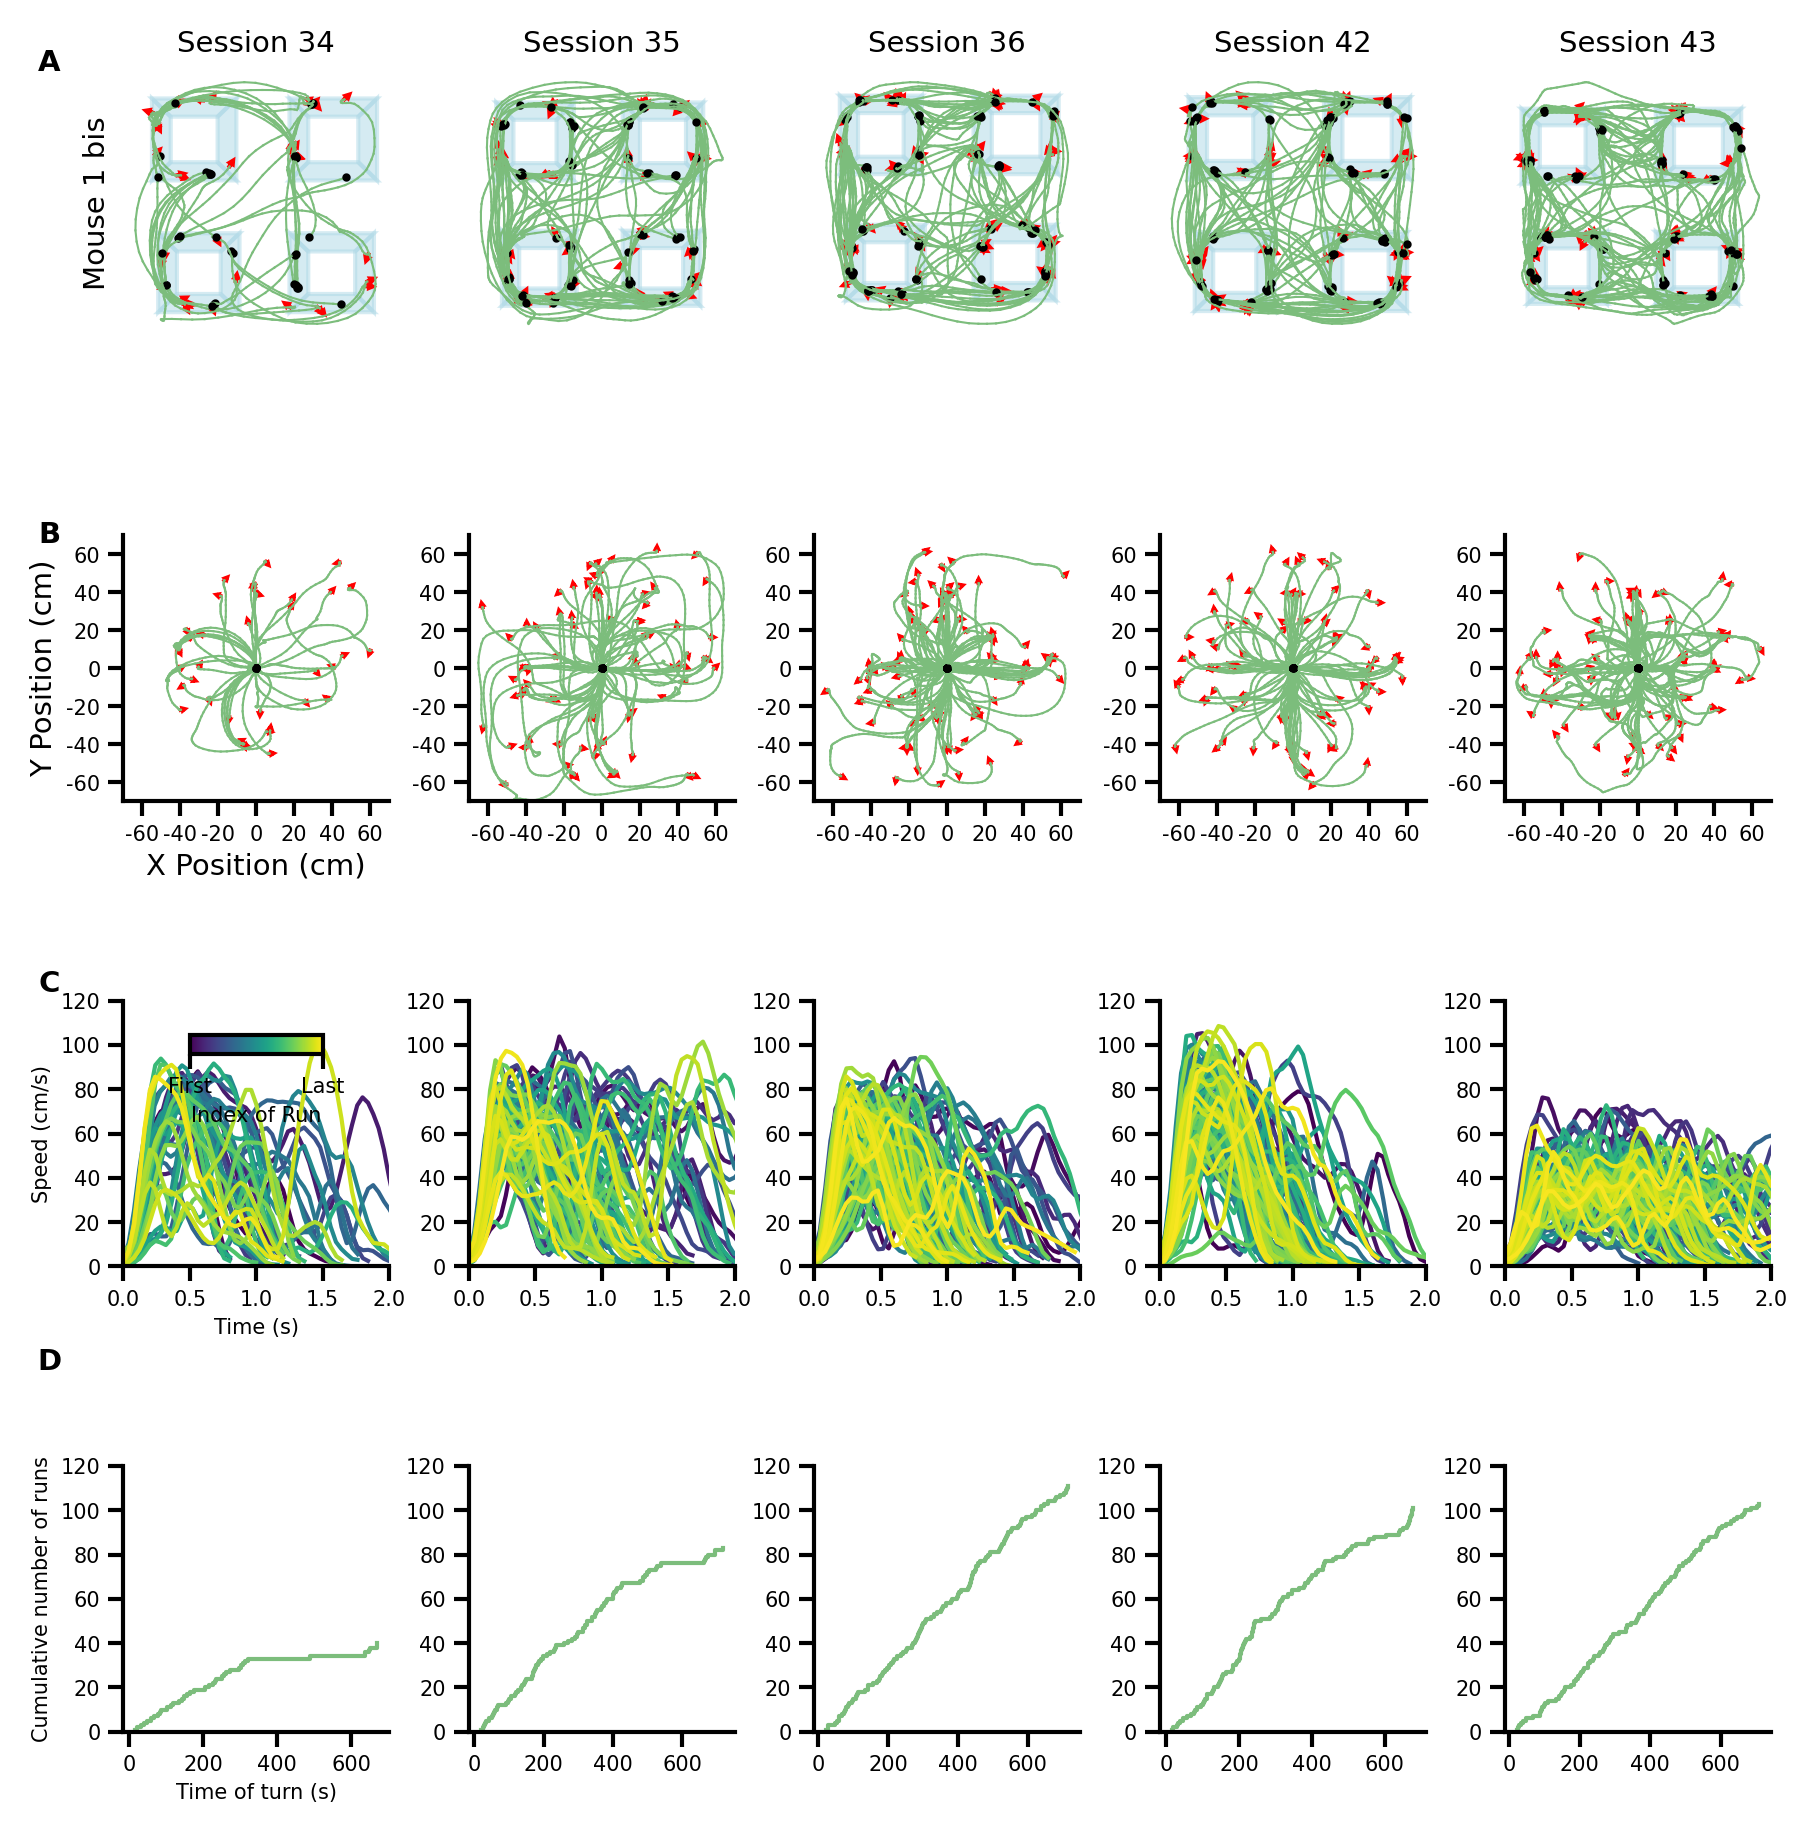

In [43]:
#sessions_to_compare = [0,5,8]
sessions_to_compare = [33,34,35,41,42]
sessions_to_analyse = sessions_to_analyse[session_lower_limit:session_upper_limit]

time_start = None
time_end = None
video_resolution = [512,512]

mice_to_compare = ['MOU4551', 'MOU3988'] #['MOUKA290', 'MOUKA313'] #["MOUKA290","MOUKA300"]


folder_path_mouse_to_analyse = f"/LocalData/ForagingMice/4TowerTaskMethodPaper/MaudData/{mice_to_compare[0]}"

##################################################################################################################################################################################################################

video_resolution = 512, 512 # this gives the resolution in pixel of the video recorded(trajectory of the mice in the maze)  
trapeze_width = 40 # rewards are delivered in the maze around 4 towers,  when mice a switch from one trapze to another

first_epoch_to_plot = 50 # 40 93
last_epoch_to_plot = 150 # 50 99

def force_aspect(ax,ratio=1):
    ratio = 1.0
    x_left, x_right = ax.get_xlim()
    y_low, y_high = ax.get_ylim()
    ax.set_aspect(abs((x_right-x_left)/(y_low-y_high))*ratio)

fig=plt.figure(figsize=(cm2inch(18), cm2inch(20)), dpi=300, constrained_layout=False, facecolor='w')
gs = fig.add_gridspec(4, 1 , hspace=0.1)

#########################################


row1 = gs[0].subgridspec(1, 5, wspace=.3, hspace=.3)
ax_11 = plt.subplot(row1[0], aspect="equal")
ax_12 = plt.subplot(row1[1], aspect="equal")
ax_13 = plt.subplot(row1[2], aspect="equal")
ax_14 = plt.subplot(row1[3], aspect="equal")
ax_15 = plt.subplot(row1[4], aspect="equal")

ax_11.text(-0.1, 0.5, 'Mouse 1 bis', color='black', rotation=90, va='center', ha='center', transform=ax_11.transAxes, fontsize=7)
ax_11.text(0.5, 1.1, f'Session {sessions_to_compare[0]+1}', va='center', ha='center', transform=ax_11.transAxes, fontsize=7)
ax_12.text(0.5, 1.1, f'Session {sessions_to_compare[1]+1}', va='center', ha='center', transform=ax_12.transAxes, fontsize=7)
ax_13.text(0.5, 1.1, f'Session {sessions_to_compare[2]+1}', va='center', ha='center', transform=ax_13.transAxes, fontsize=7)
ax_14.text(0.5, 1.1, f'Session {sessions_to_compare[3]+1}', va='center', ha='center', transform=ax_14.transAxes, fontsize=7)
ax_15.text(0.5, 1.1, f'Session {sessions_to_compare[4]+1}', va='center', ha='center', transform=ax_15.transAxes, fontsize=7)

ax_1 = [ax_11,ax_12,ax_13,ax_14,ax_15]

for j in range(len(sessions_to_compare)):

    plot_run_type(folder_path_mouse_to_analyse, session_list[mice_to_compare[0]][sessions_to_compare[j]], ax_1[j], runtype='run_between_towers', q=4, time_start=time_start, time_end=time_end)

force_aspect(ax_11,ratio=1)
force_aspect(ax_12,ratio=1)
force_aspect(ax_13,ratio=1)
force_aspect(ax_14,ratio=1)
force_aspect(ax_15,ratio=1)

fig.text(.09, 0.85, 'A', weight='bold', va='center', ha='center', fontsize=7)

#########################################

row2 = gs[1].subgridspec(1, 5, wspace=.3, hspace=.3)
ax_21 = plt.subplot(row2[0], aspect="equal")
ax_22 = plt.subplot(row2[1], aspect="equal")
ax_23 = plt.subplot(row2[2], aspect="equal")
ax_24 = plt.subplot(row2[3], aspect="equal")
ax_25 = plt.subplot(row2[4], aspect="equal")

ax_2 = [ax_21,ax_22,ax_23,ax_24,ax_25]


for k in range(len(sessions_to_compare)):

    plot_runs_between_towers_origin(folder_path_mouse_to_analyse, session_list[mice_to_compare[0]][sessions_to_compare[k]], ax_2[k], q=4, time_start=time_start, time_end=time_end, show_xlabel= True if k==0 else False, show_ylabel= True if k==0 else False, show_legend= False, xlim=(-70,70), ylim=(-70,70))
    ax_2[k].set_xticks([-60,-40,-20, 0, 20, 40, 60])
    ax_2[k].set_yticks([-60,-40,-20, 0, 20, 40, 60])

fig.text(.09, 0.65, 'B', weight='bold', va='center', ha='center', fontsize=7)

#########################################

row3 = gs[2].subgridspec(1, 5, wspace=.3, hspace=.3)
ax_31 = plt.subplot(row3[0])
ax_32 = plt.subplot(row3[1])
ax_33 = plt.subplot(row3[2])
ax_34 = plt.subplot(row3[3])
ax_35 = plt.subplot(row3[4])

ax_3 = [ax_31, ax_32, ax_33, ax_34, ax_35]

for l in range(len(sessions_to_compare)):

    plot_runs_between_speed_profiles(folder_path_mouse_to_analyse, session_list[mice_to_compare[0]][sessions_to_compare[l]], ax_3[l], time_start=time_start, time_end=time_end, xlim=(0,2), ylim=(0,120), show_xlabel= True if l==0 else False, show_ylabel= True if l==0 else False, show_color_bar= True if l==0 else False)


force_aspect(ax_31,ratio=1)
force_aspect(ax_32,ratio=1)
force_aspect(ax_33,ratio=1)
force_aspect(ax_34,ratio=1)
force_aspect(ax_35,ratio=1)

fig.text(.09, 0.46, 'C', weight='bold', va='center', ha='center', fontsize=7)

#########################################

row4 = gs[3].subgridspec(1, 5, wspace=.3, hspace=.3)
ax_41 = plt.subplot(row4[0])
ax_42 = plt.subplot(row4[1])
ax_43 = plt.subplot(row4[2])
ax_44 = plt.subplot(row4[3])
ax_45 = plt.subplot(row4[4])

ax_4 = [ax_41, ax_42, ax_43, ax_44, ax_45]

for m in range(len(sessions_to_compare)):

    plot_cumulated_runs_time_profile(folder_path_mouse_to_analyse, session_list[mice_to_compare[0]][sessions_to_compare[m]], ax_4[m], time_start=time_start, time_end=time_end, xlim=None, ylim=[0,120], show_xlabel= True if m==0 else False, show_ylabel= True if m==0 else False, show_legend=False)


force_aspect(ax_41,ratio=1)
force_aspect(ax_42,ratio=1)
force_aspect(ax_43,ratio=1)
force_aspect(ax_44,ratio=1)
force_aspect(ax_45,ratio=1)

fig.text(.09, 0.3, 'D', weight='bold', va='center', ha='center', fontsize=7)


#########################################

# row4 = gs[3].subgridspec(1, 2, wspace=.3, hspace=.3)
# ax_41 = plt.subplot(row4[0])
# ax_42 = plt.subplot(row4[1])

# x_ticks = [0,4,9,14,19]

# plot_learning_curves(path_to_data_folder, CW_mice, mouse_mean_run_speed_persession, ax_41, ylabel='Mean speed of runs ', show_background_legend=False, data_label=[None,None], data_color='black', x_ticks=x_ticks)
# plot_learning_curves(path_to_data_folder, CW_mice, mouse_total_runs_persession, ax_42, ylabel='Number of runs', show_background_legend=False, data_label=[None,None], data_color='black', x_ticks=x_ticks)


# fig.text(.09, 0.3, 'D', weight='bold', va='center', ha='center', fontsize=7)

#########################################
 
plt.show()


In [39]:
-

SyntaxError: invalid syntax (476313318.py, line 1)

In [431]:
CW_mice

['MOU3975', 'MOU3988', 'MOU3991', 'MOU4551', 'MOU4552', 'MOU4623']

In [432]:
mouse_total_runs_persession['MOU3975']

[[1, 41],
 [2, 22],
 [3, 57],
 [4, 43],
 [5, 65],
 [6, 72],
 [7, 81],
 [8, 75],
 [9, 66],
 [10, 60],
 [11, 71],
 [12, 67],
 [13, 75],
 [14, 68],
 [15, 111],
 [16, 68],
 [17, 78],
 [18, 69],
 [19, 89],
 [20, 70],
 [21, 3],
 [22, 61],
 [23, 67],
 [24, 65],
 [25, 50],
 [26, 48],
 [27, 87],
 [28, 85],
 [29, 77],
 [30, 59],
 [31, 48],
 [32, 83],
 [33, 75],
 [34, 57],
 [35, 98],
 [36, 139],
 [37, 167],
 [38, 140],
 [39, 120],
 [40, 110],
 [41, 158],
 [42, 152],
 [43, 48],
 [44, 119],
 [45, 158],
 [46, 188]]

In [202]:
session_data['all_trapezes_coordinates_cm']

{'NW': {'N': [[19.28, 71.76], [32.08, 71.76], [41.35, 81.03], [10.01, 81.03]],
  'E': [[32.08, 71.76], [32.08, 57.67], [41.35, 48.4], [41.35, 81.03]],
  'S': [[32.08, 57.67], [19.28, 57.67], [10.01, 48.4], [41.35, 48.4]],
  'W': [[19.28, 57.67], [19.28, 71.76], [10.01, 81.03], [10.01, 48.4]]},
 'NE': {'N': [[61.19, 72.69], [74.17, 72.69], [83.44, 81.96], [51.92, 81.96]],
  'E': [[74.17, 72.69], [74.17, 57.85], [83.44, 48.58], [83.44, 81.96]],
  'S': [[74.17, 57.85], [61.19, 57.85], [51.92, 48.58], [83.44, 48.58]],
  'W': [[61.19, 57.85], [61.19, 72.69], [51.92, 81.96], [51.92, 48.58]]},
 'SW': {'N': [[20.21, 29.85], [33.56, 29.85], [42.83, 39.13], [10.94, 39.13]],
  'E': [[33.56, 29.85], [33.56, 18.91], [42.83, 9.64], [42.83, 39.13]],
  'S': [[33.56, 18.91], [20.21, 18.91], [10.94, 9.64], [42.83, 9.64]],
  'W': [[20.21, 18.91], [20.21, 29.85], [10.94, 39.13], [10.94, 9.64]]},
 'SE': {'N': [[61.19, 30.04], [74.17, 30.04], [83.44, 39.31], [51.92, 39.31]],
  'E': [[74.17, 30.04], [74.17, 

In [203]:
a = np.array([[1,2,3],
              [4,5,6],
              [7,8,9]])

np.diagonal(a, offset=-1, axis1=0, axis2=1)

array([4, 8])

In [204]:
session_data['all_epochs']['run_around_tower'][0]

[[0, 33],
 ['NW', 'W'],
 ['NW', 'E'],
 {'Rewarded': False,
  'direction': 'CCW',
  'num_trapezeswitch': 2,
  'max_rewards': np.int64(12)},
 {'epoch_time': np.float64(15.015),
  'epoch_duration': np.float64(1.3179999999999978),
  'epoch_distance': np.float64(33.55090401529213),
  'epoch_meanspeed': np.float64(25.45592110416706),
  'epoch_maxspeed': np.float64(34.02051871777641)}]

In [44]:
np.sqrt(5000)

np.float64(70.71067811865476)